# Introduction

This analysis hopes to compute the observed probability of grid operation for a given hour of the day.

# Method

I define the probability of power availability as 

$$ \frac{\textrm{number valid observations of power at time t}}
        {\textrm{number of valid observations of power and blackout at time t}} $$
        
A valid observation of power at time t is defined as having a time series observation of the power at time t.

A valid observation of blackout at time t, is defined as time t falling in a recorded gap observation.

- construct a one-minute time index
- create a boolean column for valid power observation
- create a boolean column for valid blackout observation
- aggregate these observations over the time of day
- sum and divide to give a probability measure

# Results

- grid shows above 90% availability at most times of day
- microgrid shows evening use with zero use during day
- maximum availibility of 80% on peak evening times

# Next Work

- create a noon to noon x-axis
- grab statistics from the data

In [1]:
%load_ext autoreload

In [4]:
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import WP19_analysis as wpa


def wpa_create_downtime_boolean_message(energy_data, messages):
    # create boolean array of whether timestamp falls in recorded power gap
    index = pd.DatetimeIndex(start=wpa.get_start_time(energy_data),
                             end=wpa.get_end_time(energy_data),
                             freq='1T').values
    power_down = messages[messages['message']=='Power Down'].index.values
    power_up = messages[messages['message']=='Power Up'].index.values

    downtime = []
    for i in index:
        # if the insertion point of the index is one greater for the power_down time, you are in a gap
        if np.searchsorted(power_down, i) == np.searchsorted(power_up, i) + 1:
            downtime.append(1)
        else:
            downtime.append(0)
    
    return pd.Series(index=index, data=downtime)

def wpa_create_uptime_boolean_timestamp(energy_data):
    # create boolean array of whether timestamp is during a valid power observation
    acc_energy = energy_data['kWh export']
    rs_acc_energy = acc_energy.resample('1T').asfreq()
    boolean_uptime = (~rs_acc_energy.isnull()).astype(int)
    return boolean_uptime

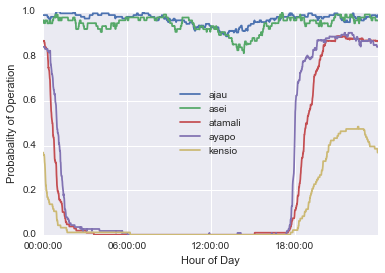

In [16]:
for rfd in wpa.raw_file_data:
    vname = rfd['village_name']
    energy_data = wpa.load_timeseries_file(vname + '-clean.csv')
    messages = wpa.load_message_file(vname + '-messages.csv')

    uptime = wpa_create_uptime_boolean_timestamp(energy_data)
    downtime = wpa_create_downtime_boolean_message(energy_data, messages) 
    assert uptime.index[0] == downtime.index[0], 'different start times'
    assert uptime.index[-1] == downtime.index[-1], 'different end times'

    # make single data frame from these two series
    up_and_down_time = pd.DataFrame({'uptime':uptime, 'downtime':downtime})

    # aggregate by the minute to get probabilities
    aggregated = up_and_down_time.groupby(up_and_down_time.index.time).sum()
    aggregated['probability'] = aggregated['uptime'] / (aggregated['downtime'] + aggregated['uptime'])

    ax = aggregated['probability'].plot(grid=True, label=vname, legend=True)
    ax.set_xlabel('Hour of Day')
    ax.set_xticks(('00:00', '06:00', '12:00', '18:00'))
    ax.set_ylabel('Probabality of Operation')
    ax.legend(loc='center')

plt.savefig('../plots/uptime-probability.png')